In [2]:
%pip install yfinance pandas matplotlib

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached yfinance-0.2.51-py2.py3-none-any.whl (104 kB)
  Using cached pandas-2.2.3-cp39-cp39-macosx_10_9_x86_64.whl (12.6 MB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_10_12_x86_64.whl (7.9 MB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_x86_64.whl (6.9 MB)
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Using cached lxml-5.3.0-cp39-cp39-macosx_10_9_x86_64.whl (4.4 MB)
  Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
  Using cached peewee-3.17.8.tar.gz (948 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (py

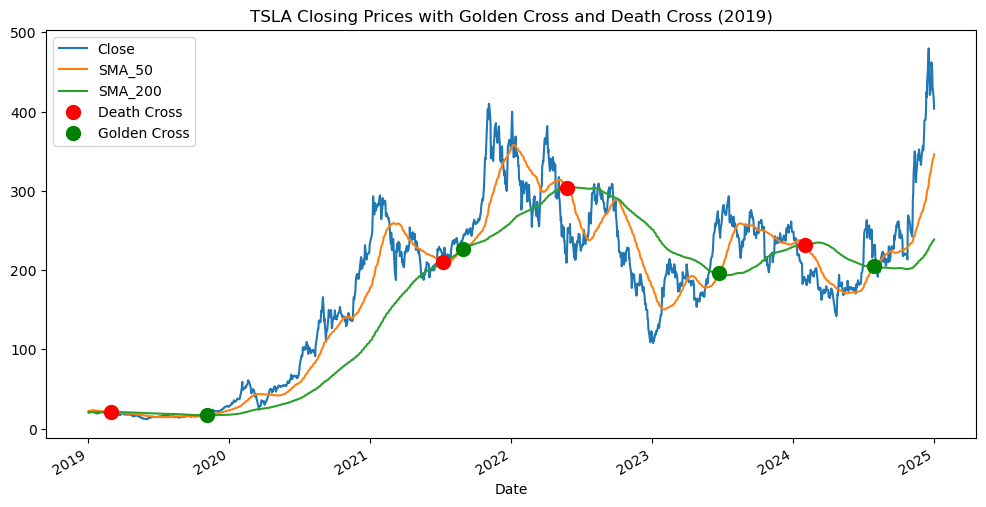

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Retrieve price history dataframe from yfinance
tesla_df = yf.Ticker("TSLA").history(period="max")

# Calculate 50-day and 200-day SMAs
tesla_df['SMA_50'] = tesla_df['Close'].rolling(window=50).mean()
tesla_df['SMA_200'] = tesla_df['Close'].rolling(window=200).mean()

# Identifying the "Golden Cross" and "Death Cross"
tesla_df['Signal'] = 0 
tesla_df.loc[tesla_df['SMA_50'] > tesla_df['SMA_200'], 'Signal'] = 1
tesla_df.loc[tesla_df['SMA_50'] < tesla_df['SMA_200'], 'Signal'] = -1

# Creating a column to mark crossover points
tesla_df['Crossover'] = tesla_df['Signal'].diff()

# Using a smaller date range for better visualization
tesla_df_small = tesla_df.loc['2019':'2024']

# Plot with Golden Cross and Death Cross
fig, ax = plt.subplots(figsize=(12, 6))
tesla_df_small[['Close', 'SMA_50', 'SMA_200']].plot(ax=ax, title="TSLA Closing Prices with Golden Cross and Death Cross (2019)")

# Highlighting Golden Cross and Death Cross points
crosses = tesla_df_small[tesla_df_small['Crossover'] != 0]
for idx, row in crosses.iterrows():
    if row['Crossover'] == 2:
        plt.plot(idx, row['SMA_50'], 'go', markersize=10, label='Golden Cross' if 'Golden Cross' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    elif row['Crossover'] == -2:
        plt.plot(idx, row['SMA_50'], 'ro', markersize=10, label='Death Cross' if 'Death Cross' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    plt.legend()
    
plt.show()